# PROJET D'OPTIMISATION - GRP 4 

## Récupération de données 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Question 1

### Question 4

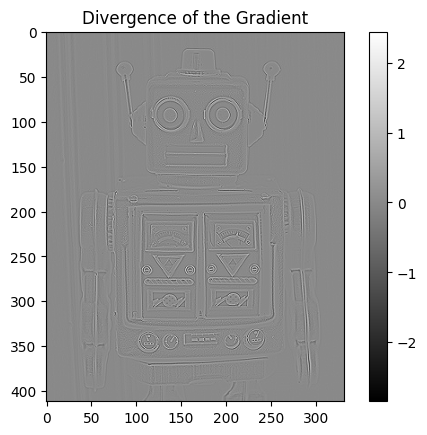

In [ ]:
def grad(u):
    """Returns the discrete gradient of matrix u."""
    (n, m) = u.shape
    
    # grad_x
    grad_x = u[1:n, :] - u[0:n-1, :]
    grad_x = np.append(grad_x, np.zeros((1, m), dtype=float), axis=0)  # zeros for line i=n

    # grad_y
    grad_y = u[:, 1:m] - u[:, 0:m-1]
    grad_y = np.append(grad_y, np.zeros((n, 1), dtype=float), axis=1)  # zeros for column j=m

    return np.array([grad_x, grad_y])

def div(v):
    """Returns the discrete divergence of vector field v."""
    (n, m) = v.shape[:2]  # v is a vector of size n x m x 2
    v_x = v[:, :, 0]
    v_y = v[:, :, 1]
    div = np.zeros((n, m))
    
    # Handling along x
    div[0, :] += v_x[0, :]
    div[n-1, :] += -v_x[n-2, :]
    div[1:n-1, :] += (v_x[1:n-1, :] - v_x[0:n-2, :])
    
    # Handling along y
    div[:, 0] += v_y[:, 0]
    div[:, m-1] += -v_y[:, m-2]
    div[:, 1:m-1] += (v_y[:, 1:m-1] - v_y[:, 0:m-2])
    
    return div

# Compute the gradient and divergence
gradient = grad(u)
laplacien = div(gradient.transpose(1, 2, 0))  # Transpose to match the expected shape

# Plot the divergence
plt.imshow(laplacien, cmap='gray')
plt.colorbar()
plt.title("Divergence of the Laplac")
plt.show()
